<a href="https://colab.research.google.com/github/saij19/Statistical-Analysis-TUDortmund/blob/main/Statistical_Analysis_TUDortmund.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Load data as pandas dataframe
file_path = '/content/drive/MyDrive/dortmund/data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Task 1

Aim - To prepare the data for analysis by addressing any missing values present

In [5]:
data.isnull().sum()

game_id          0
passing_quote    2
winner           2
dtype: int64

In [6]:
data = data.dropna()

In [7]:
data = data.reset_index(drop=True)

# Task 2

Aim – This task aimed to restructure the data to facilitate analysis of passing rates in relation to game outcomes (win, lose, tie).

In [8]:
data['winner'] = data['winner'].apply(lambda x: 1 if x == 'Yes' else 0)

In [9]:
def merge_game_data(game_id):
  game_data = data[data['game_id'] == game_id]
  team1_rate = game_data.iloc[0]['passing_quote']
  team2_rate = game_data.iloc[1]['passing_quote']

  # Winner assignment based on 'Yes' indicating any team's win or tie
  if game_data.iloc[0]['winner'] == 1:
    winner = 'Team 1'
  elif game_data.iloc[1]['winner'] == 1:
    winner = 'Team 2'
  else:
    winner = 'Tie'  # Handles tie case

  return team1_rate, team2_rate, winner

In [10]:
# Create new features
team1_rates, team2_rates, winners = [], [], []
for game_id in data['game_id'].unique():
  team1_rate, team2_rate, winner = merge_game_data(game_id)
  team1_rates.append(team1_rate)
  team2_rates.append(team2_rate)
  winners.append(winner)

In [11]:
# Combine features and target variable into a dataframe
features = pd.DataFrame({'team1_rate': team1_rates, 'team2_rate': team2_rates})
target = pd.DataFrame({'winner': winners})

In [12]:
# Save processed data to CSV
processed_data_path = '/content/drive/MyDrive/dortmund/processed_data.csv'
features_with_target = pd.concat([features, target], axis=1, join='inner')
features_with_target.to_csv(processed_data_path, index=False)
print(f"Processed data saved to: {processed_data_path}")

Processed data saved to: /content/drive/MyDrive/dortmund/processed_data.csv


In [13]:
processed_data = pd.read_csv(processed_data_path)
processed_data

,team1_rate,team2_rate,winner
0,72.0,91.0,Team 2
1,82.0,86.0,Team 1
2,82.0,79.0,Team 1
3,79.0,77.0,Team 2
4,85.0,77.0,Tie
...,...,...,...
147,84.0,76.0,Tie
148,76.0,91.0,Team 2
149,78.0,81.0,Team 2
150,73.0,74.0,Tie


# Task 3

Aim – This task aimed to explore the distribution and characteristics of passing rates within different winner groups (winners, losers, ties) using descriptive statistics and visualizations.

## Descriptive Statistics

In [14]:
print(processed_data.describe(include='all'))  # Summary statistics

        team1_rate  team2_rate  winner
count   152.000000  152.000000     152
unique         NaN         NaN       3
top            NaN         NaN  Team 1
freq           NaN         NaN      71
mean     80.585526   78.776316     NaN
std       6.800316    7.022384     NaN
min      59.000000   53.000000     NaN
25%      76.000000   75.000000     NaN
50%      82.000000   79.000000     NaN
75%      86.000000   84.000000     NaN
max      92.000000   91.000000     NaN


In [15]:
# Winners
winners = processed_data[processed_data["winner"] != "Tie"]
winning_team = winners["winner"]

# Combine Team 1 and Team 2 Passing Rates for Winners
winning_rates = []
for idx, row in winners.iterrows():
    if row["winner"] == "Team 1":
        winning_rates.append(row["team1_rate"])
    else:
        winning_rates.append(row["team2_rate"])

print(sum(winning_rates)/len(winning_rates))

81.07894736842105


In [16]:
# Ties
tie_games = processed_data[processed_data["winner"] == "Tie"]

# Combine Team 1 and Team 2 Passing Rates for Ties
tie_rates = pd.concat([tie_games["team1_rate"], tie_games["team2_rate"]])  # Combine rates for both teams in ties

print(sum(tie_rates)/len(tie_rates))

78.21052631578948


## Box Plot

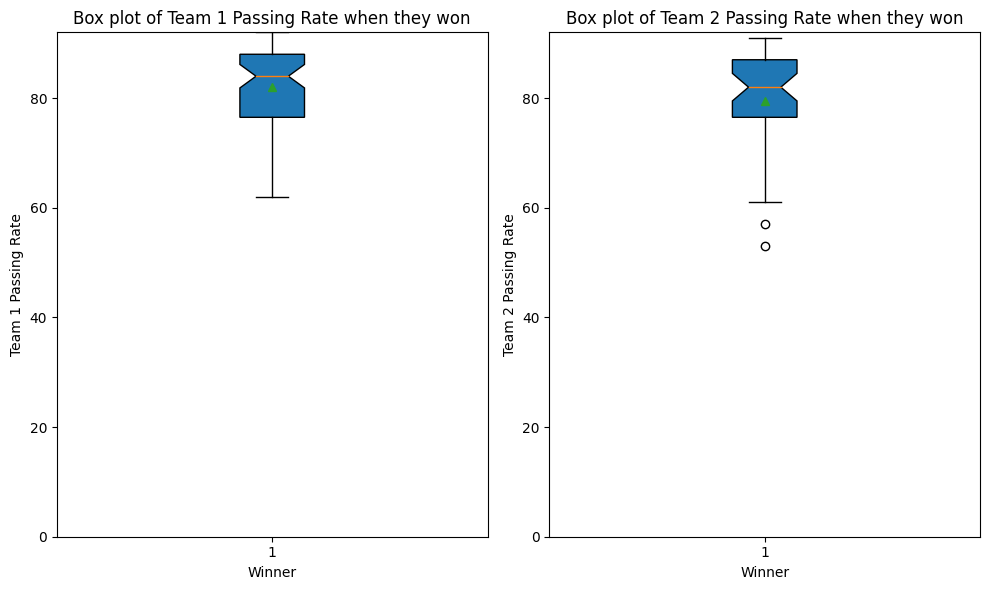

In [17]:
plt.figure(figsize=(10, 6))

# Team 1 Passing Rates
team1_rates = processed_data["team1_rate"]

# Team 2 Passing Rates
team2_rates = processed_data["team2_rate"]

winners = processed_data["winner"]

# Create subplots for Team 1 and Team 2 for games they won
team1_winning_rates = team1_rates[winners == "Team 1"] # Team 1's passing rate distribution for games they won
team2_winning_rates = team2_rates[winners == "Team 2"] # Team 2's passing rate distribution for games they won

max_value = max(max(team1_winning_rates), max(team2_winning_rates)) #same y-axis

# Subplot 1: Team 1 Passing Rate
plt.subplot(1, 2, 1)
plt.boxplot(team1_winning_rates, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.ylim(0, max_value)
plt.xlabel('Winner')
plt.ylabel('Team 1 Passing Rate')
plt.title('Box plot of Team 1 Passing Rate when they won')

# Subplot 2: Team 2 Passing Rate
plt.subplot(1,2, 2)
plt.boxplot(team2_winning_rates, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.ylim(0, max_value)
plt.xlabel('Winner')
plt.ylabel('Team 2 Passing Rate')
plt.title('Box plot of Team 2 Passing Rate when they won')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Task 4

Aim - This section examines whether the passing rates in data follow a normal distribution

## Histogram

<Figure size 640x480 with 0 Axes>

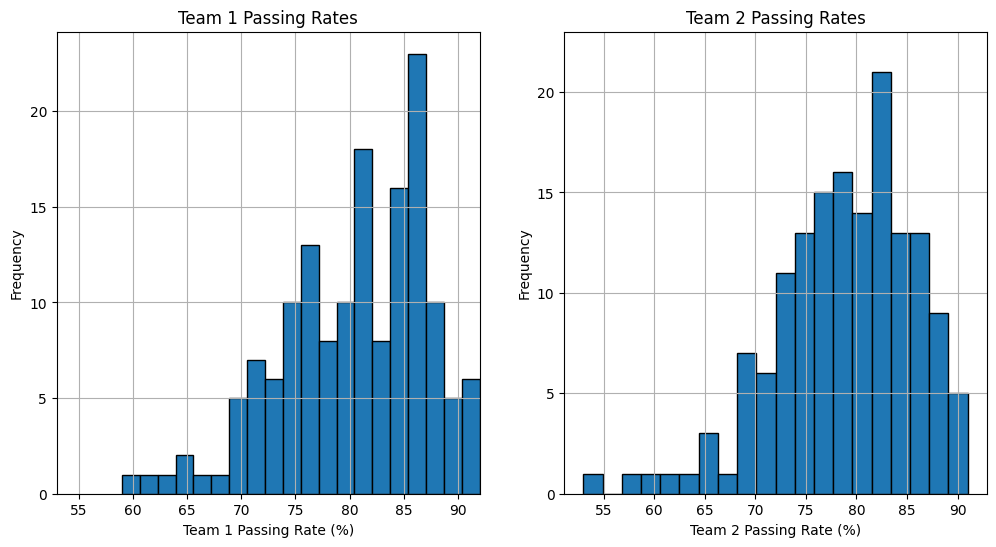

In [18]:
#Team 1 and Team 2 Passing rates

# Team 1 Passing Rates
team1_rates = processed_data["team1_rate"]

# Team 2 Passing Rates
team2_rates = processed_data["team2_rate"]

# Find the minimum and maximum values across both datasets
min_rate = min(min(team1_rates), min(team2_rates))
max_rate = max(max(team1_rates), max(team2_rates))

# Calculate maximum frequency
max_frequency = 0
for data in [team1_rates, team2_rates]:
  counts, bins, patches = plt.hist(data, bins=20)
  max_frequency = max(max_frequency, max(counts))

plt.clf()
# Create figure for two subplots
plt.figure(figsize=(12, 6))
plt.clf()

# Team 1 Histogram (Left Subplot)
plt.subplot(1, 2, 1)
plt.hist(team1_rates, bins=20, edgecolor="black")
plt.xlabel("Team 1 Passing Rate (%)")
plt.ylabel("Frequency")
plt.title("Team 1 Passing Rates")
plt.grid(True)

# Common x-axis limits for both subplots
plt.xlim(min_rate, max_rate)

# Team 2 Histogram (Right Subplot)
plt.subplot(1, 2, 2)
plt.hist(team2_rates, bins=20, edgecolor="black")
plt.xlabel("Team 2 Passing Rate (%)")
plt.ylabel("Frequency")
plt.title("Team 2 Passing Rates")
plt.grid(True)

plt.ylim(0, max_frequency)  # Common y-axis limits for both subplots

plt.show()

In [19]:
# Separate passing rates based on win/loss
team1_win = processed_data[processed_data['winner'] == 'Team 1']['team1_rate']
team2_win = processed_data[processed_data['winner'] == 'Team 2']['team2_rate']
team1_lose = processed_data[(processed_data['winner'] != 'Team 1') & (processed_data['winner'] != 'Tie')]['team1_rate']
team2_lose = processed_data[(processed_data['winner'] != 'Team 2') & (processed_data['winner'] != 'Tie')]['team2_rate']

<Figure size 640x480 with 0 Axes>

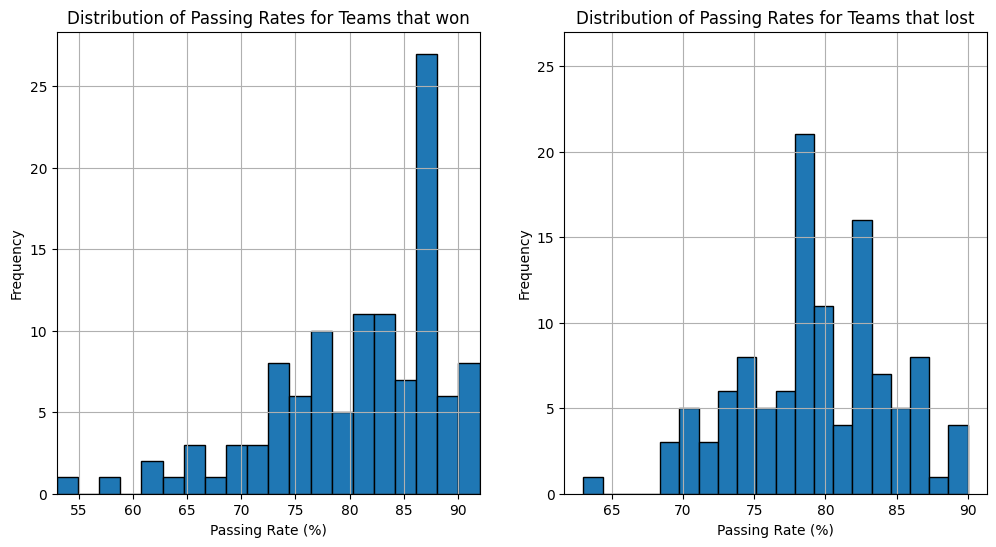

In [20]:
#winners vs loosers - histogram

win_rates = np.concatenate((team1_win, team2_win))
lose_rates = np.concatenate((team1_lose, team2_lose))

# Find the minimum and maximum values across both datasets
min_rate = min(min(win_rates), min(lose_rates))
max_rate = max(max(win_rates), max(lose_rates))

# Calculate maximum frequency
max_frequency = 0
for data in [win_rates, lose_rates]:
  counts, bins, patches = plt.hist(data, bins=20)
  max_frequency = max(max_frequency, max(counts))

plt.clf()
# Create figure for two subplots
plt.figure(figsize=(12, 6))
plt.clf()

# histogram for Winners
plt.subplot(1, 2, 1)
plt.hist(win_rates, bins=20, edgecolor="black", label="Winners")
plt.xlabel("Passing Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Passing Rates for Teams that won")
plt.grid(True)

# Common x-axis limits for both subplots
plt.xlim(min_rate, max_rate)

# histogram for Losers
plt.subplot(1, 2, 2)
plt.hist(lose_rates, bins=20, edgecolor="black", label="Winners")
plt.xlabel("Passing Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Passing Rates for Teams that lost")
plt.grid(True)

plt.ylim(0, max_frequency)  # Common y-axis limits for both subplots

plt.show()

<Figure size 640x480 with 0 Axes>

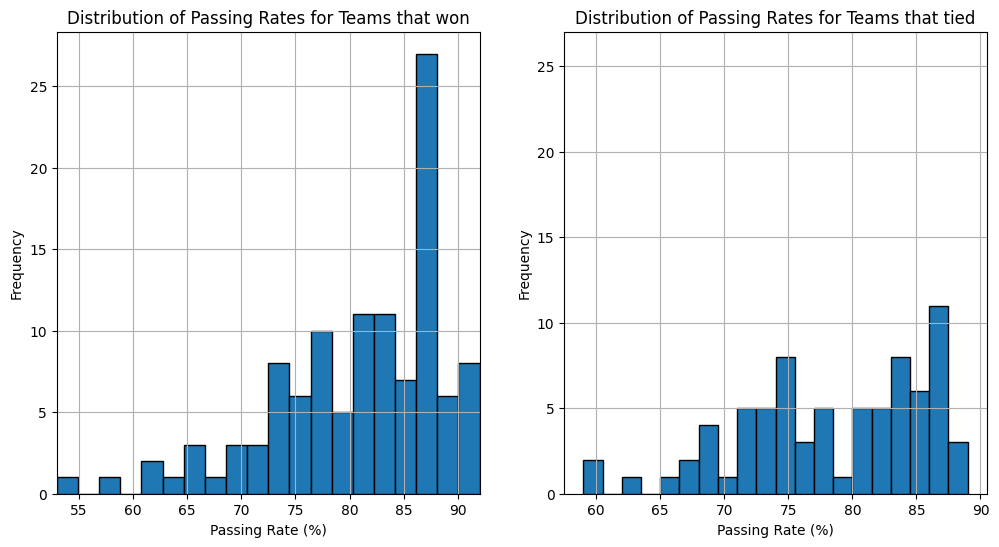

In [21]:
# winner vs ties

# Ties
tie_games = processed_data[processed_data["winner"] == "Tie"]
tie_rates = pd.concat([tie_games["team1_rate"], tie_games["team2_rate"]])  # Combine rates for both teams in ties

# Find the minimum and maximum values across both datasets
min_rate = min(min(win_rates), min(tie_rates))
max_rate = max(max(win_rates), max(tie_rates))

# Calculate maximum frequency
max_frequency = 0
for data in [win_rates, tie_rates]:
  counts, bins, patches = plt.hist(data, bins=20)
  max_frequency = max(max_frequency, max(counts))

plt.clf()
# Create figure for two subplots
plt.figure(figsize=(12, 6))
plt.clf()

# histogram for Winners
plt.subplot(1, 2, 1)
plt.hist(win_rates, bins=20, edgecolor="black", label="Winners")
plt.xlabel("Passing Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Passing Rates for Teams that won")
plt.grid(True)

# Common x-axis limits for both subplots
plt.xlim(min_rate, max_rate)

# histogram for Ties
plt.subplot(1, 2, 2)
plt.hist(tie_rates, bins=20, edgecolor="black", label="Winners")
plt.xlabel("Passing Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Passing Rates for Teams that tied")
plt.grid(True)

plt.ylim(0, max_frequency)  # Common y-axis limits for both subplots

plt.show()

## QQ Plot

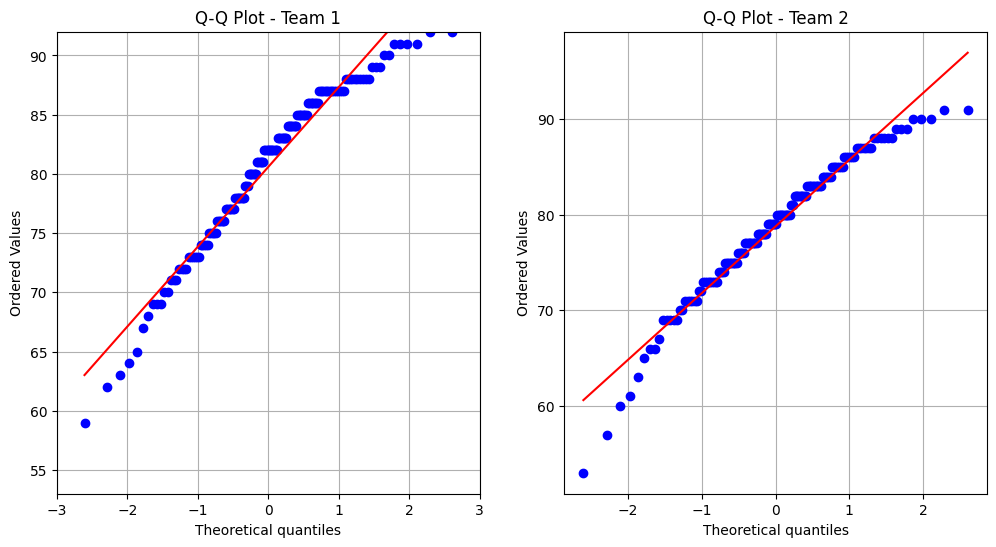

In [22]:
# Team 1 Passing Rates
team1_rates = processed_data["team1_rate"]

# Team 2 Passing Rates
team2_rates = processed_data["team2_rate"]

# Find the overall minimum and maximum values for both datasets
min_value = min(min(team1_rates), min(team2_rates))
max_value = max(max(team1_rates), max(team2_rates))

# Create a QQ plot
plt.figure(figsize=(12,6))

# QQ plot for Team 1
plt.subplot(1, 2, 1)
stats.probplot(team1_rates, dist="norm", plot=plt)
plt.title('Q-Q Plot - Team 1')
plt.grid(True)

# Common axis limits for both Q-Q plots
plt.xlim(-3, 3)
plt.ylim(min_value, max_value)

# QQ plot for Team 2
plt.subplot(1, 2, 2)
stats.probplot(team2_rates, dist="norm", plot=plt)
plt.title('Q-Q Plot - Team 2')
plt.grid(True)

plt.show()

In [23]:
# Separate passing rates based on win/loss
team1_win = processed_data[processed_data['winner'] == 'Team 1']['team1_rate']
team2_win = processed_data[processed_data['winner'] == 'Team 2']['team2_rate']
team1_lose = processed_data[(processed_data['winner'] != 'Team 1') & (processed_data['winner'] != 'Tie')]['team1_rate']
team2_lose = processed_data[(processed_data['winner'] != 'Team 2') & (processed_data['winner'] != 'Tie')]['team2_rate']

win_rates = np.concatenate((team1_win, team2_win))
lose_rates = np.concatenate((team1_lose, team2_lose))

# Ties
tie_games = processed_data[processed_data["winner"] == "Tie"]
tie_rates = pd.concat([tie_games["team1_rate"], tie_games["team2_rate"]])  # Combine rates for both teams in ties

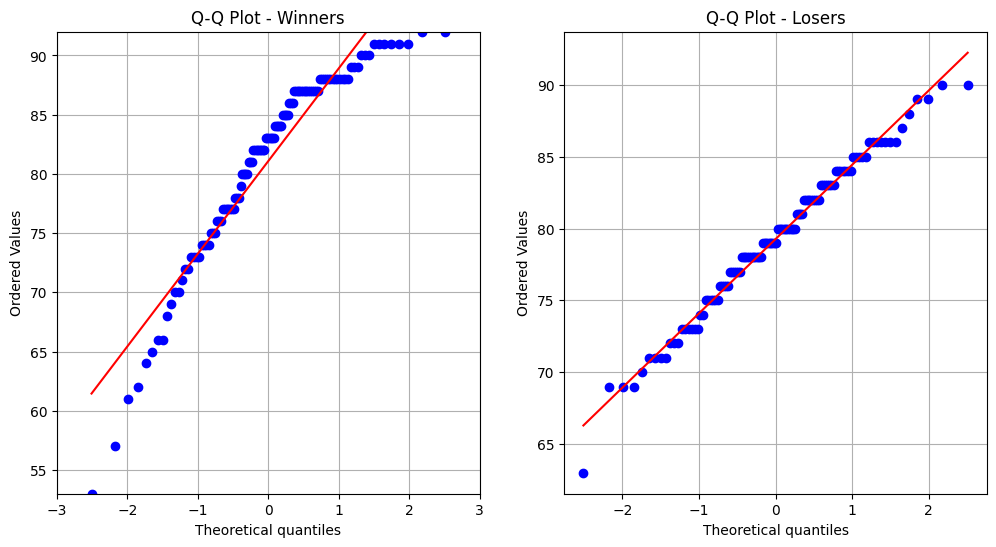

In [24]:
# Winners vs Losers

# Find the overall minimum and maximum values for both datasets
min_value = min(min(win_rates), min(lose_rates))
max_value = max(max(win_rates), max(lose_rates))

# Create a QQ plot
plt.figure(figsize=(12,6))

# QQ plot for Winners
plt.subplot(1, 2, 1)
stats.probplot(win_rates, dist="norm", plot=plt)
plt.title('Q-Q Plot - Winners')
plt.grid(True)

# Common axis limits for both Q-Q plots
# plt.xlim(min_value, max_value)
plt.xlim(-3, 3)
plt.ylim(min_value, max_value)

# QQ plot for Tie
plt.subplot(1, 2, 2)
stats.probplot(lose_rates, dist="norm", plot=plt)
plt.title('Q-Q Plot - Losers')
plt.grid(True)

plt.show()

## Shaprio-Wilks test

In [27]:
passing_rates = processed_data["team1_rate"]  # Modify this as needed

# Perform Shapiro-Wilk test
shapiro_test = stats.shapiro(passing_rates)

# Print the test statistic and p-value
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation
if shapiro_test[1] > 0.05:  # Adjust significance level if needed
    print("The data appears to be normally distributed (p-value > 0.05).")
else:
    print("The data may not be normally distributed (p-value <= 0.05).")

Shapiro-Wilk test statistic: 0.9581329822540283
p-value: 0.0001485094107920304
The data may not be normally distributed (p-value <= 0.05).


In [29]:
passing_rates = processed_data["team2_rate"]  # Modify this as needed

# Perform Shapiro-Wilk test
shapiro_test = stats.shapiro(passing_rates)

# Print the test statistic and p-value
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation
if shapiro_test[1] > 0.05:  # Adjust significance level if needed
    print("The data appears to be normally distributed (p-value > 0.05).")
else:
    print("The data may not be normally distributed (p-value <= 0.05).")

Shapiro-Wilk test statistic: 0.963897168636322
p-value: 0.0005156590486876667
The data may not be normally distributed (p-value <= 0.05).


In [30]:
# Separate passing rates based on win/loss
team1_win = processed_data[processed_data['winner'] == 'Team 1']['team1_rate']
team2_win = processed_data[processed_data['winner'] == 'Team 2']['team2_rate']
team1_lose = processed_data[(processed_data['winner'] != 'Team 1') & (processed_data['winner'] != 'Tie')]['team1_rate']
team2_lose = processed_data[(processed_data['winner'] != 'Team 2') & (processed_data['winner'] != 'Tie')]['team2_rate']

win_rates = np.concatenate((team1_win, team2_win))
lose_rates = np.concatenate((team1_lose, team2_lose))

In [31]:
#winner rates

# Perform Shapiro-Wilk test
shapiro_test = stats.shapiro(win_rates)

# Print the test statistic and p-value
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation
if shapiro_test[1] > 0.05:  # Adjust significance level if needed
    print("The data appears to be normally distributed (p-value > 0.05).")
else:
    print("The data may not be normally distributed (p-value <= 0.05).")

Shapiro-Wilk test statistic: 0.9145990014076233
p-value: 2.0200225208100164e-06
The data may not be normally distributed (p-value <= 0.05).


In [32]:
#losers rates

# Perform Shapiro-Wilk test
shapiro_test = stats.shapiro(lose_rates)

# Print the test statistic and p-value
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation
if shapiro_test[1] > 0.05:  # Adjust significance level if needed
    print("The data appears to be normally distributed (p-value > 0.05).")
else:
    print("The data may not be normally distributed (p-value <= 0.05).")

Shapiro-Wilk test statistic: 0.986456573009491
p-value: 0.3102757930755615
The data appears to be normally distributed (p-value > 0.05).


In [34]:
# Ties
tie_games = processed_data[processed_data["winner"] == "Tie"]
tie_rates = pd.concat([tie_games["team1_rate"], tie_games["team2_rate"]])  # Combine rates for both teams in ties

# Perform Shapiro-Wilk test
shapiro_test = stats.shapiro(tie_rates)

# Print the test statistic and p-value
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation
if shapiro_test[1] > 0.05:  # Adjust significance level if needed
    print("The data appears to be normally distributed (p-value > 0.05).")
else:
    print("The data may not be normally distributed (p-value <= 0.05).")

Shapiro-Wilk test statistic: 0.9453475475311279
p-value: 0.0025809723883867264
The data may not be normally distributed (p-value <= 0.05).


## To check if we can proceed with Two sample test test even though we got "data may not be normal"

In [35]:
# Assuming 'winners' and 'tie_games' are DataFrames from your previous code

winner_sample_size = len(winners)
tie_game_sample_size = len(tie_games)

print("Sample size for winners:", winner_sample_size)
print("Sample size for tie games:", tie_game_sample_size)


Sample size for winners: 152
Sample size for tie games: 38


# Task 5

**Research Question 1** – Is there a statistically significant difference in the average passing rate between winning and losing games?

### HYPOTHESIS -

Null hypothesis (H₀): There is no statistically significant difference in the average passing rates between winning and losing teams.

Alternative Hypothesis (H₁): There is a difference in passing rates between winners and losers.

## Two sample T-test

In [36]:
# Two sample t-test to analyse statistically significant difference in passing rates between teams that won and those who couldnt win and to answer that Has the winner of a game a higher passing rate than the lose

# Separate passing rates based on win/loss
team1_win = processed_data[processed_data['winner'] == 'Team 1']['team1_rate']
team2_win = processed_data[processed_data['winner'] == 'Team 2']['team2_rate']
team1_lose = processed_data[(processed_data['winner'] != 'Team 1') & (processed_data['winner'] != 'Tie')]['team1_rate']
team2_lose = processed_data[(processed_data['winner'] != 'Team 2') & (processed_data['winner'] != 'Tie')]['team2_rate']

# Combine win and lose rates into single arrays
win_rates = np.concatenate((team1_win, team2_win))
lose_rates = np.concatenate((team1_lose, team2_lose))

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(win_rates, lose_rates)

# Print results
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
  print("Reject the null hypothesis: There is a statistically significant difference in passing rates between teams that win and teams that lose.")
else:
  print("Fail to reject the null hypothesis: There is no statistically significant difference in passing rates between teams that win and teams that lose.")

t-statistic: 2.0279, p-value: 0.0437
Reject the null hypothesis: There is a statistically significant difference in passing rates between teams that win and teams that lose.


The results of the two-sample t-test indicate that there is a statistically significant difference in passing rates between teams that win and teams that lose.

> `t-statistic: 2.0279`

The t-statistic measures the difference between the means of the two groups (win and lose) in units of the standard error. A positive t-statistic indicates that the mean passing rate for winning teams is higher than the mean passing rate for losing teams.

The positive t-statistic further hints that winners might have a higher average passing rate compared to losers, but this is not definitive without further analysis.

> `p-value: 0.0437`

The p-value represents the probability of observing a t-statistic as extreme or more extreme than 2.0279, assuming that the null hypothesis is true (i.e., there is no difference in passing rates between winning and losing teams). A p-value less than 0.05 is generally considered to be statistically significant.

**Conclusion:**
Since the p-value (0.0437) is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in passing rates between teams that win and teams that lose. This means that winning teams tend to have higher passing rates than losing teams.

While this suggests winners might have a higher average passing rate, it's important to note that the data may not be perfectly normally distributed (as per Shapiro-Wilk test results). To confirm this finding, so non-parametric alternative - Mann-Whitney U test is performed for comparing passing rates.

## Mann Whitney U test

In [37]:
# Perform Mann-Whitney U test - non parametric test

from scipy.stats import mannwhitneyu

u_statistic, p_value = mannwhitneyu(win_rates, lose_rates)

# Print results
print(f"U statistic: {u_statistic:.4f}, p-value: {p_value:.4f}")

# Interpret results (similar to the t-test)
if p_value < 0.05:
  print("Reject the null hypothesis: There is a statistically significant difference in passing rates between winners and losers.")
else:
  print("Fail to reject the null hypothesis: There is no statistically significant difference in passing rates between winners and losers based on the Mann-Whitney U test.")

U statistic: 8052.0000, p-value: 0.0018
Reject the null hypothesis: There is a statistically significant difference in passing rates between winners and losers.


The low p-value (0.0018) suggests we can reject the null hypothesis, which stated there's no difference in passing rates between winners and losers.

## Support of visualisation - Boxplot

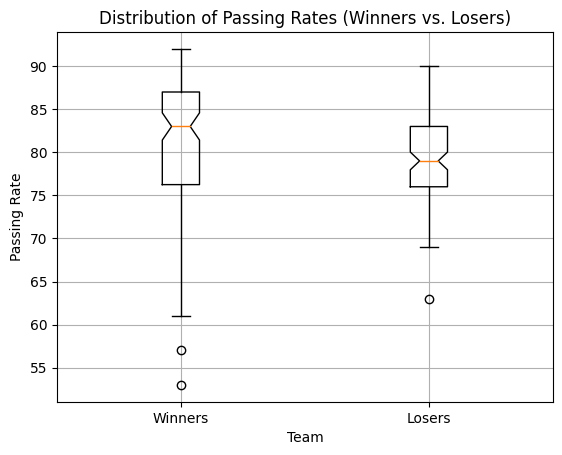

In [39]:
plt.boxplot([win_rates, lose_rates], labels=["Winners", "Losers"], notch=True)

plt.xlabel("Team")
plt.ylabel("Passing Rate")
plt.title("Distribution of Passing Rates (Winners vs. Losers)")
plt.grid(True)

plt.show()

## Median calculation

In [40]:
# Calculate medians
winners_median = np.median(win_rates)
losers_median = np.median(lose_rates)

# Compare medians
if winners_median > losers_median:
  print(f"winners_median = {winners_median} losers_median = {losers_median}")
  print("Winners have a higher median passing rate compared to losers.")
else:
  print(f"winners_median = {winners_median} losers_median = {losers_median}")
  print("Losers have a higher median passing rate compared to winners (unlikely scenario based on previous tests).")

winners_median = 83.0 losers_median = 79.0
Winners have a higher median passing rate compared to losers.


## Effect Size - Cohen's D

In [41]:
# Calculate means and pooled standard deviation
winners_mean = np.mean(win_rates)
losers_mean = np.mean(lose_rates)
pooled_std = np.std(np.concatenate((win_rates, lose_rates)))

# Calculate Cohen's d
cohen_d = (winners_mean - losers_mean) / pooled_std

print("Cohens D = ",cohen_d)

if cohen_d >= 0.8:
    print("There is a large effect size in passing rates between winners and losers.")
elif cohen_d >= 0.5:
    print("There is a medium effect size in passing rates between winners and losers.")
elif cohen_d >= 0.2:
    print("There is a small effect size in passing rates between winners and losers.")
else:
    print("There is no effect size in passing rates between winners and losers.")

Cohens D =  0.26736271117123855
There is a small effect size in passing rates between winners and losers.


# Task 6

**Research Question 2** – Is there a larger difference in passing rates within winning games compared to tie games?

### HYPOTHESIS -

Null hypothesis (H₀): There is no statistically significant difference in the average passing rate between winning and tie games.

Alternative Hypothesis (H₁): There is a statistically significant difference in the average passing rate between winning and tie games.

In [42]:
# Calculate the difference in passing rates for winning games
winning_diff = [abs(rate1 - rate2) for rate1, rate2 in zip(winning_rates[::2], winning_rates[1::2])]

# Calculate the difference in passing rates for tie games
tie_diff = np.abs(tie_rates.diff().dropna())

## Two Sample T-test

In [43]:
# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(winning_diff, tie_diff)

# Print results
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
  print("Reject the null hypothesis: There is a statistically significant difference in passing rates between teams that win and teams that lose.")
else:
  print("Fail to reject the null hypothesis: There is no statistically significant difference in passing rates between teams that win and teams that lose.")

t-statistic: 0.4464, p-value: 0.6560
Fail to reject the null hypothesis: There is no statistically significant difference in passing rates between teams that win and teams that lose.


## Mann-Whitney U test

In [44]:
u_statistic, p_value = mannwhitneyu(winning_diff, tie_diff)

# Print results
print(f"U statistic: {u_statistic:.4f}, p-value: {p_value:.4f}")

# Interpret results (similar to the t-test)
if p_value < 0.05:
  print("Reject the null hypothesis: There is a statistically significant difference in passing rates between winners and losers.")
else:
  print("Fail to reject the null hypothesis: There is no statistically significant difference in passing rates between winners and losers based on the Mann-Whitney U test.")

U statistic: 2191.5000, p-value: 0.8055
Fail to reject the null hypothesis: There is no statistically significant difference in passing rates between winners and losers based on the Mann-Whitney U test.


## Support of visualisation - Boxplot

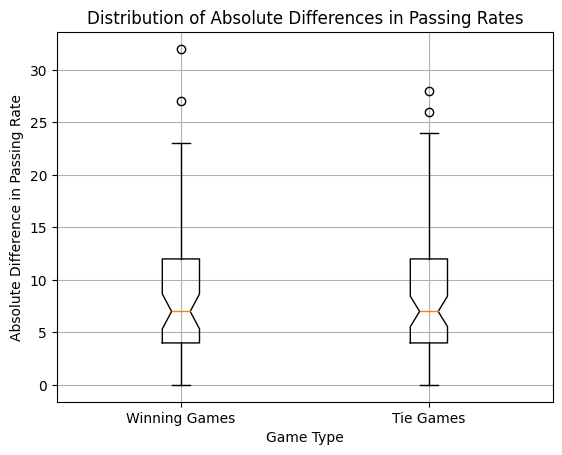

In [46]:
plt.boxplot([winning_diff, tie_diff], labels=["Winning Games", "Tie Games"], notch=True)

plt.xlabel("Game Type")
plt.ylabel("Absolute Difference in Passing Rate")
plt.title("Distribution of Absolute Differences in Passing Rates")
plt.grid(True)

plt.show()

## Median Calculation

In [49]:
# Calculate medians
winners_median = np.median(winning_diff)
tie_median = np.median(tie_diff)

# Compare medians
if winners_median > tie_median:
  print(f"winners_median = {winners_median} tie_median = {tie_median}")
  print("Winners have a higher median passing rate compared to tie.")
elif winners_median == tie_median:
  print(f"winners_median = {winners_median} tie_median = {tie_median}")
  print("ties have same median passing rate compared to winners.")
else:
  print(f"winners_median = {winners_median} tie_median = {tie_median}")
  print("ties have a higher median passing rate compared to winners.")

winners_median = 7.0 tie_median = 7.0
ties have same median passing rate compared to winners.


## Effect size - Cohen's D

In [50]:
# Calculate means and pooled standard deviation
winners_mean = np.mean(winning_diff)
tie_mean = np.mean(tie_diff)
pooled_std = np.std(np.concatenate((winning_diff, tie_diff)))

# Calculate Cohen's d
cohen_d = (winners_mean - tie_mean) / pooled_std

print("Cohens D = ",cohen_d)

if cohen_d >= 0.8:
    print("There is a large effect size in passing rates between winners and tie.")
elif cohen_d >= 0.5:
    print("There is a medium effect size in passing rates between winners and tie.")
elif cohen_d >= 0.2:
    print("There is a small effect size in passing rates between winners and tie.")
else:
    print("There is no effect size in passing rates between winners and tie.")

Cohens D =  0.0789885704911432
There is no effect size in passing rates between winners and tie.


# Conclusion -

1.	Do winning teams have a statistically different passing rate compared to losing teams?

> Key Result - Yes, there's a significant difference (p-value < 0.05) in passing rates. Winning teams boast a higher median passing rate, suggesting a connection between successful passing and winning. However, the effect size was small, indicating other factors likely influence winning besides passing.

2. Is the difference in passing rate larger within winning games compared to ties?

> Key Result – No significant difference (p > 0.05) was found in passing rates between winning and tie games. This suggests passing rate may not be a major factor distinguishing wins from ties. In other words, teams with both high and lower passing rates can emerge victorious in games that end in a tie. This finding highlights the complex nature of game outcomes, where various factors beyond passing success can contribute to a tied result.





**Overall, the findings suggest that passing rate is a factor influencing game outcomes, with higher passing rates associated with winning teams. However, the difference in passing rates between winning and tie games seems negligible.**